# Readme
- Used the code provided by Lev
- All rows which included nulls were removed. Arguably, filling nulls may make predictions worse. Possible solution - run a model to fill those nulls. here, we just droped almost 30% of the data.
- After investigating the features - most of the features are 'end of the day' data. Our mission, arguably, is to predict whether will be a jump in the price today, while we do this prediction at the morning. Therefore, we yet have no data for 'today'. That means, we need to predict whether there will be a jump today using data from yesterday. For that, used in this model - Data devided into data, and target value. In Data, first row was removed. In target Value - last row was removed (for same amount of rows). Then, dataset was synchronized.
- We ran the models.
- Chose RF model (as we used it before). After adjusting the parameters - got the best results it could give.
- $R^2 = -0.39$. While $R^2$ error is negative, it means that simply guessing 0 or 1 would provide better prediction than our model. This model is not usefull  

# Table of Content
[Main Mission](#Main-Mission)<br>
[Imports](#Imports)<br>
[Data Overview](#Data-Overview)<br>
[Feature Explanations](#Feature-Explanations)<br>
[Data Cleaning](#Data-Cleaning)<br>
[EDA](#EDA)<br>
[Model Preparation](#Model-Preparation)<br>
[Choosing the Model](#Choosing-the-Model)<br>

---

## Main Mission
1. In this model, we assume we have the starting price of Bitcoin, and we try to predict the closing price of BTC each day.
2. We compare the closing price we predicted with the closing price we got in the given dataset.
3. We calculate the precentile difference between starting and closing prices.
4. Our goal is to predict "jumps" of $|\pm 0.03|$ in price between openning and closing prices of BTC each day

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, accuracy_score
)
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,matthews_corrcoef,log_loss,precision_recall_curve,mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV

## Data Overview

In [2]:
# Loading the Excel file and selecting the relevant sheet
file_path = 'Bitcoin-Historical-Data.xlsx'  # Replace with your file's path
sheet_name = "Bitcoin Historical Data (1)"
bitcoin_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Using pandas to display an overview of the dataset
print("### Data Information ###")
bitcoin_data.info()  # Overview of data types and non-null counts

# Generating descriptive statistics as a DataFrame
description_df = bitcoin_data.describe()

# Displaying the description DataFrame
print("\n### Data Description as DataFrame ###")

# Alternatively, to render it nicely in a Jupyter Notebook, use:
description_df

### Data Information ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        2648 non-null   object        
 1   DATE                        2648 non-null   datetime64[ns]
 2   Price                       2648 non-null   float64       
 3   Open                        2648 non-null   float64       
 4   High                        2648 non-null   float64       
 5   Low                         2648 non-null   float64       
 6   Vol.                        2648 non-null   object        
 7   Change %                    2648 non-null   float64       
 8   SN&P Adjusted               2648 non-null   float64       
 9   DXY Adjusted                2648 non-null   float64       
 10  GOLD Adjusted               2648 non-null   float64       
 11  ETH Price                   264

,DATE,Price,Open,High,Low,Change %,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
count,2648,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,1828.000000,1845.000000,2648.000000
mean,2020-09-05 12:00:00,20901.424282,20877.398716,21392.479003,20323.478210,0.002369,3480.044532,97.470220,1630.579018,1194.447572,65.314845,755.466767,0.000009,78.090188,0.301360
min,2017-01-21 00:00:00,893.800000,892.900000,905.700000,841.500000,-0.391800,2191.900000,88.170000,1174.160000,10.460000,10.010000,1.000000,0.000002,34.497800,0.000000
25%,2018-11-13 18:00:00,7118.375000,7114.825000,7329.950000,6886.950000,-0.014000,2760.200000,93.340250,1305.457500,220.437500,52.750000,428.000000,0.000003,62.690100,0.000000
50%,2020-09-05 12:00:00,12345.850000,12266.800000,13053.850000,11719.250000,0.001300,3353.600000,96.491000,1727.485000,670.665000,64.340000,759.000000,0.000006,75.580000,0.000000
75%,2022-06-29 06:00:00,32099.525000,32033.675000,33176.125000,30504.025000,0.019100,4185.050000,101.796000,1870.490000,1868.935000,76.680000,1090.000000,0.000009,91.935100,1.000000
max,2024-04-21 00:00:00,73066.300000,73066.700000,73740.900000,71338.400000,0.255600,5245.800000,114.047000,2390.450000,4808.380000,123.700000,1439.000000,0.000042,170.550500,1.000000
std,NaN,17572.649566,17556.214865,17991.385482,17078.564132,0.038534,798.124795,5.275653,291.668473,1150.976099,18.314031,388.774747,0.000009,21.483822,0.458935


---

# Feature Explanations
### <u>Date</u>
   The date of the exploration day.
### <u>Price</u> 
The **closing price** of BTC that day. (This feature is basically our target value. For if we predict this, we can calculate Change% and our initial target value.)
### <u>Open</u> 
The **opening price** of BTC that day.
### <u>High</u> 
The **highest price** of BTC that day.
### <u>Low</u> 
The **lowest price** of BTC that day.
### <u>Vol</u>
BTC volume measures the number of bitcoins that have been bought and sold during a specific timeframe. Since our timeframe is daily, this data is calculated at the end of the day.
### <u>Change %</u> 
The correlation between opening and closing prices of BTC that day. Therefore, it may be considered as our target value, so we can use this data for later comparison of our predictions. But for now, this feature should be dropped.
### <u>The S&P Adjusted</u> 
value could mean:
- Adjusted Closing Price: This is a recalculated value of the S&P 500 index that accounts for corporate actions like stock splits or dividends. It ensures that historical price data remains comparable over time.
- Adjusted Index Value: It might reflect the total return of the index, which includes price changes and assumes dividends are reinvested.
- The S&P 500 Index is tied to the stock market, which operates only during business days (Monday through Friday, excluding market holidays). Since the stock market is closed on weekends.<br>
The S&P 500 Adjusted value is typically calculated and reported at the **end** of the trading day, based on:
- The closing prices of all constituent stocks.
- Adjustments for dividends, splits, or other factors (if applicable).
### <u>DXY Adjusted</u>
refers to the US Dollar Index (DXY), which measures the value of the US dollar relative to a basket of foreign currencies, but with some adjustment applied.<br>
DXY values are typically updated continuously during trading hours. However, a "daily adjusted" DXY is usually the end-of-day (EOD) value, calculated based on the closing rates of the currencies in the basket.<br>
The DXY Adjusted is tied to the stock market, which operates only during business days (Monday through Friday, excluding market holidays). Since the stock market is closed on weekends.<br>
The US Dollar Index (DXY) measures the strength of the US dollar against six major currencies:
- Euro (EUR) (the largest component, ~57.6%)
- Japanese Yen (JPY)
- British Pound Sterling (GBP)
- Canadian Dollar (CAD)
- Swedish Krona (SEK)
- Swiss Franc (CHF)
### <u>Gold Adjusted</u>
refers to the adjusted closing price of gold for a specific trading day.<br>
The Gold Adjusted is tied to the stock market, which operates only during business days (Monday through Friday, excluding market holidays). Since the stock market is closed on weekends.<br>
### <u>ETH Price</u>
ETH Price refers to the value of one unit of Ethereum (ETH) expressed in terms of a fiat currency, typically US dollars (USD). After online investigation, we assume that this feature is the Closing Price of ETH in the given day. Altho, the data is a bit incorrect.
### <u>ETH Volume</u>
ETH Volume (ETH Vol) refers to the total amount of Ethereum (ETH) traded over a specific timeframe, typically calculated as the sum of all buy and sell transactions involving ETH.<br>
Likely represents the cumulative volume at the end of the day, as most datasets aggregate and finalize metrics at the close of a day.
### <u>Oil Price Adjusted</u>
The term "Oil Price Adjusted" typically refers to the price of oil after accounting for specific adjustments, which could include:
Inflation Adjustment, Currency Adjustments, Market-Specific Adjustments, Average Daily Price.<br>
Most likely, also the end of the day price, and does not change over the weekends.
### <u>Days From the Last Halving</u>
Days from the last halving refers to the number of days that have passed since the most recent Bitcoin halving event. A halving is a predefined event in Bitcoin's protocol that reduces the block reward (the amount of BTC miners receive for successfully mining a block) by half. These events occur approximately every 4 years (or every 210,000 blocks).
### <u>BTC Hashprice</u>
BTC Hashprice refers to the revenue miners earn for each unit of computational power (measured in terahashes per second, or TH/s) they contribute to the Bitcoin network. It is an important metric for Bitcoin miners as it helps them understand the profitability of their mining operations.<br>
Hashprice is the dollar value earned per terahash (TH/s) of mining power per day. It combines the Bitcoin mining rewards (block rewards + transaction fees) with the prevailing BTC price to estimate the income miners generate for their computational work.
### <u>Crypto Volatility Index</u>
The Crypto Volatility Index (CVI) is a metric designed to measure the expected volatility of the cryptocurrency market, similar to the VIX (Volatility Index) in traditional finance. It provides traders and investors with an indicator of how much price fluctuation is anticipated in the near future for cryptocurrencies like Bitcoin (BTC) or Ethereum (ETH).<br>
It quantifies market sentiment regarding future price volatility.<br>
High CVI indicates that the market expects significant price swings (either up or down), while a low CVI suggests relative stability.

---

**As we can see, most of our data is <u>end of the day</u> data. so in our model we will initially drop the columns "Change%" and "Target Value", and define the "Price" column (closing price each day) as our target value.**

---

## Data Cleaning
In this section, we will "clean" the data - adjust Date, missing values, convert to numeric, column drops, etc.

In [3]:
# Checking for missing values in the dataset
missing_values = bitcoin_data.isnull().sum()

# Filtering columns with more than 0 missing values
missing_values_filtered = missing_values[missing_values > 0]

# Converting the result to a DataFrame for better display
missing_values_df = missing_values_filtered.to_frame(name="Missing Values")
missing_values_df.index.name = "Column"

# Displaying the DataFrame
print("### Columns with Missing Values ###")
print(missing_values_df)

### Columns with Missing Values ###
                         Missing Values
Column                                 
BTC_Hashprice                       820
Crypto Volatility Index             803


In [4]:
def convert_to_numeric(value):
    """
    Converts strings like '1.2K', '3M', '4B' into numeric values.
    """
    if isinstance(value, str):
        if value.endswith('K'):
            return float(value[:-1]) * 1_000
        elif value.endswith('M'):
            return float(value[:-1]) * 1_000_000
        elif value.endswith('B'):
            return float(value[:-1]) * 1_000_000_000
        else:
            return float(value.replace(',', ''))  # Removes commas if present
    return value

# Specifying columns to convert
columns_to_convert = ['Vol.', 'ETH Vol.']  # Replace with your actual column names containing 'K', 'M', 'B'

# Applying the function to the specified columns
for column in columns_to_convert:
    bitcoin_data[column] = bitcoin_data[column].apply(convert_to_numeric)

# Verifying the conversion
print("### Converted Columns Preview ###")
print(bitcoin_data[columns_to_convert].head())

### Converted Columns Preview ###
       Vol.  ETH Vol.
0   45170.0  276660.0
1   49330.0  256050.0
2  150340.0  645650.0
3   97380.0  423990.0
4  118920.0  524880.0


In [5]:
# Creating the new DataFrame
updated_bitcoin_data = bitcoin_data.copy()
updated_bitcoin_data

,Date,DATE,Price,Open,High,Low,Vol.,Change %,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
0,04/21/2024,2024-04-21,64902.8,64942.1,65680.6,64618.4,45170.0,-0.0009,4953.56,105.984,2390.45,3169.62,276660.0,83.14,2,0.000003,75.1890,0
1,04/20/2024,2024-04-20,64961.1,63817.6,65375.6,63131.7,49330.0,0.0182,4953.56,105.984,2390.45,3156.63,256050.0,83.14,1,0.000002,74.3407,0
2,04/19/2024,2024-04-19,63799.1,63480.5,65441.2,59693.3,150340.0,0.0050,4953.56,105.984,2390.45,3056.23,645650.0,83.14,1439,0.000002,73.6438,0
3,04/18/2024,2024-04-18,63481.4,61278.9,64092.4,60822.3,97380.0,0.0359,5001.89,105.982,2378.25,3064.48,423990.0,82.73,1438,0.000002,72.4399,1
4,04/17/2024,2024-04-17,61278.9,63802.3,64451.5,59820.8,118920.0,-0.0396,5007.25,105.764,2360.81,2985.82,524880.0,82.69,1437,0.000002,74.0805,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,01/25/2017,2017-01-25,894.4,893.8,905.7,883.6,37900.0,0.0007,2288.90,100.252,1200.31,10.48,26190.0,52.75,200,NaN,NaN,0
2644,01/24/2017,2017-01-24,893.8,921.5,925.6,889.2,58870.0,-0.0301,2266.70,100.058,1208.81,10.50,105210.0,53.18,199,NaN,NaN,1
2645,01/23/2017,2017-01-23,921.5,918.8,928.0,910.8,32740.0,0.0029,2257.00,100.125,1217.48,10.77,54390.0,52.75,198,NaN,NaN,0
2646,01/22/2017,2017-01-22,918.8,919.8,938.4,888.6,47930.0,-0.0011,2257.00,100.125,1217.48,10.64,140660.0,52.75,197,NaN,NaN,0


In [6]:
updated_bitcoin_data = updated_bitcoin_data.drop('Change %', axis=1)

In [7]:
updated_bitcoin_data['DATE'] = pd.to_datetime(updated_bitcoin_data['DATE'])
updated_bitcoin_data = updated_bitcoin_data.drop('Date', axis=1)
updated_bitcoin_data.head()

,DATE,Price,Open,High,Low,Vol.,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
0,2024-04-21,64902.8,64942.1,65680.6,64618.4,45170.0,4953.56,105.984,2390.45,3169.62,276660.0,83.14,2,0.000003,75.1890,0
1,2024-04-20,64961.1,63817.6,65375.6,63131.7,49330.0,4953.56,105.984,2390.45,3156.63,256050.0,83.14,1,0.000002,74.3407,0
2,2024-04-19,63799.1,63480.5,65441.2,59693.3,150340.0,4953.56,105.984,2390.45,3056.23,645650.0,83.14,1439,0.000002,73.6438,0
3,2024-04-18,63481.4,61278.9,64092.4,60822.3,97380.0,5001.89,105.982,2378.25,3064.48,423990.0,82.73,1438,0.000002,72.4399,1
4,2024-04-17,61278.9,63802.3,64451.5,59820.8,118920.0,5007.25,105.764,2360.81,2985.82,524880.0,82.69,1437,0.000002,74.0805,1


**As we said earlier, we need to drop columns "Change%" and "Target Value". But we will nedd them for future reference, so we will save them as different datasets.**

In [8]:
#change_ds = updated_bitcoin_data[['Change %']]
#target_value = updated_bitcoin_data[['Target Value']]

**Drop the features from the original dataset**

In [9]:
#updated_bitcoin_data = updated_bitcoin_data.drop('Change %', axis=1)
#updated_bitcoin_data = updated_bitcoin_data.drop('Target Value', axis=1)

In [10]:
#updated_bitcoin_data.head()

---

In [11]:
#X = X.drop(X.index[1828:2648])

In [12]:
#X

In [13]:
#X = X.drop(X.index[0])

In [14]:
#X

In [15]:
#y = y.drop(y.index[1827:2648])

In [16]:
#y

## EDA

In [17]:
print(updated_bitcoin_data.shape)

(2648, 16)


In [18]:
print(updated_bitcoin_data.dtypes)

DATE                          datetime64[ns]
Price                                float64
Open                                 float64
High                                 float64
Low                                  float64
Vol.                                 float64
SN&P Adjusted                        float64
DXY Adjusted                         float64
GOLD Adjusted                        float64
ETH Price                            float64
ETH Vol.                             float64
OIL Price Adjusted                   float64
Days from the last halving             int64
BTC_Hashprice                        float64
Crypto Volatility Index              float64
Target Value                           int64
dtype: object


In [19]:
updated_bitcoin_data.describe()

,DATE,Price,Open,High,Low,Vol.,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
count,2648,2648.000000,2648.000000,2648.000000,2648.000000,2.648000e+03,2648.000000,2648.000000,2648.000000,2648.000000,2.648000e+03,2648.000000,2648.000000,1828.000000,1845.000000,2648.000000
mean,2020-09-05 12:00:00,20901.424282,20877.398716,21392.479003,20323.478210,2.329773e+07,3480.044532,97.470220,1630.579018,1194.447572,1.138783e+07,65.314845,755.466767,0.000009,78.090188,0.301360
min,2017-01-21 00:00:00,893.800000,892.900000,905.700000,841.500000,2.600000e+02,2191.900000,88.170000,1174.160000,10.460000,2.619000e+04,10.010000,1.000000,0.000002,34.497800,0.000000
25%,2018-11-13 18:00:00,7118.375000,7114.825000,7329.950000,6886.950000,7.529250e+04,2760.200000,93.340250,1305.457500,220.437500,5.140550e+05,52.750000,428.000000,0.000003,62.690100,0.000000
50%,2020-09-05 12:00:00,12345.850000,12266.800000,13053.850000,11719.250000,1.553650e+05,3353.600000,96.491000,1727.485000,670.665000,1.080000e+06,64.340000,759.000000,0.000006,75.580000,0.000000
75%,2022-06-29 06:00:00,32099.525000,32033.675000,33176.125000,30504.025000,4.806725e+05,4185.050000,101.796000,1870.490000,1868.935000,6.792500e+06,76.680000,1090.000000,0.000009,91.935100,1.000000
max,2024-04-21 00:00:00,73066.300000,73066.700000,73740.900000,71338.400000,4.470000e+09,5245.800000,114.047000,2390.450000,4808.380000,1.790000e+09,123.700000,1439.000000,0.000042,170.550500,1.000000
std,NaN,17572.649566,17556.214865,17991.385482,17078.564132,2.122368e+08,798.124795,5.275653,291.668473,1150.976099,9.574082e+07,18.314031,388.774747,0.000009,21.483822,0.458935


In [20]:
updated_bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        2648 non-null   datetime64[ns]
 1   Price                       2648 non-null   float64       
 2   Open                        2648 non-null   float64       
 3   High                        2648 non-null   float64       
 4   Low                         2648 non-null   float64       
 5   Vol.                        2648 non-null   float64       
 6   SN&P Adjusted               2648 non-null   float64       
 7   DXY Adjusted                2648 non-null   float64       
 8   GOLD Adjusted               2648 non-null   float64       
 9   ETH Price                   2648 non-null   float64       
 10  ETH Vol.                    2648 non-null   float64       
 11  OIL Price Adjusted          2648 non-null   float64     

In [21]:
print(updated_bitcoin_data.isnull().sum())

DATE                            0
Price                           0
Open                            0
High                            0
Low                             0
Vol.                            0
SN&P Adjusted                   0
DXY Adjusted                    0
GOLD Adjusted                   0
ETH Price                       0
ETH Vol.                        0
OIL Price Adjusted              0
Days from the last halving      0
BTC_Hashprice                 820
Crypto Volatility Index       803
Target Value                    0
dtype: int64


In [22]:
# Optimized calculation using dynamic window and filtering
def optimized_support_resistance(data, window=10, threshold=0.02):
    updated_bitcoin_data['support_level'] = updated_bitcoin_data['Low'].rolling(window=window).min()
    updated_bitcoin_data['resistance_level'] = updated_bitcoin_data['High'].rolling(window=window).max()
    
    # Filter insignificant levels
    updated_bitcoin_data['filtered_support'] = updated_bitcoin_data['support_level'].where(
        updated_bitcoin_data['Low'] <= updated_bitcoin_data['support_level'] * (1 - threshold))
    updated_bitcoin_data['filtered_resistance'] = updated_bitcoin_data['resistance_level'].where(
        updated_bitcoin_data['High'] >= updated_bitcoin_data['resistance_level'] * (1 + threshold))
    
    return updated_bitcoin_data[['support_level', 'resistance_level', 'filtered_support', 'filtered_resistance']]


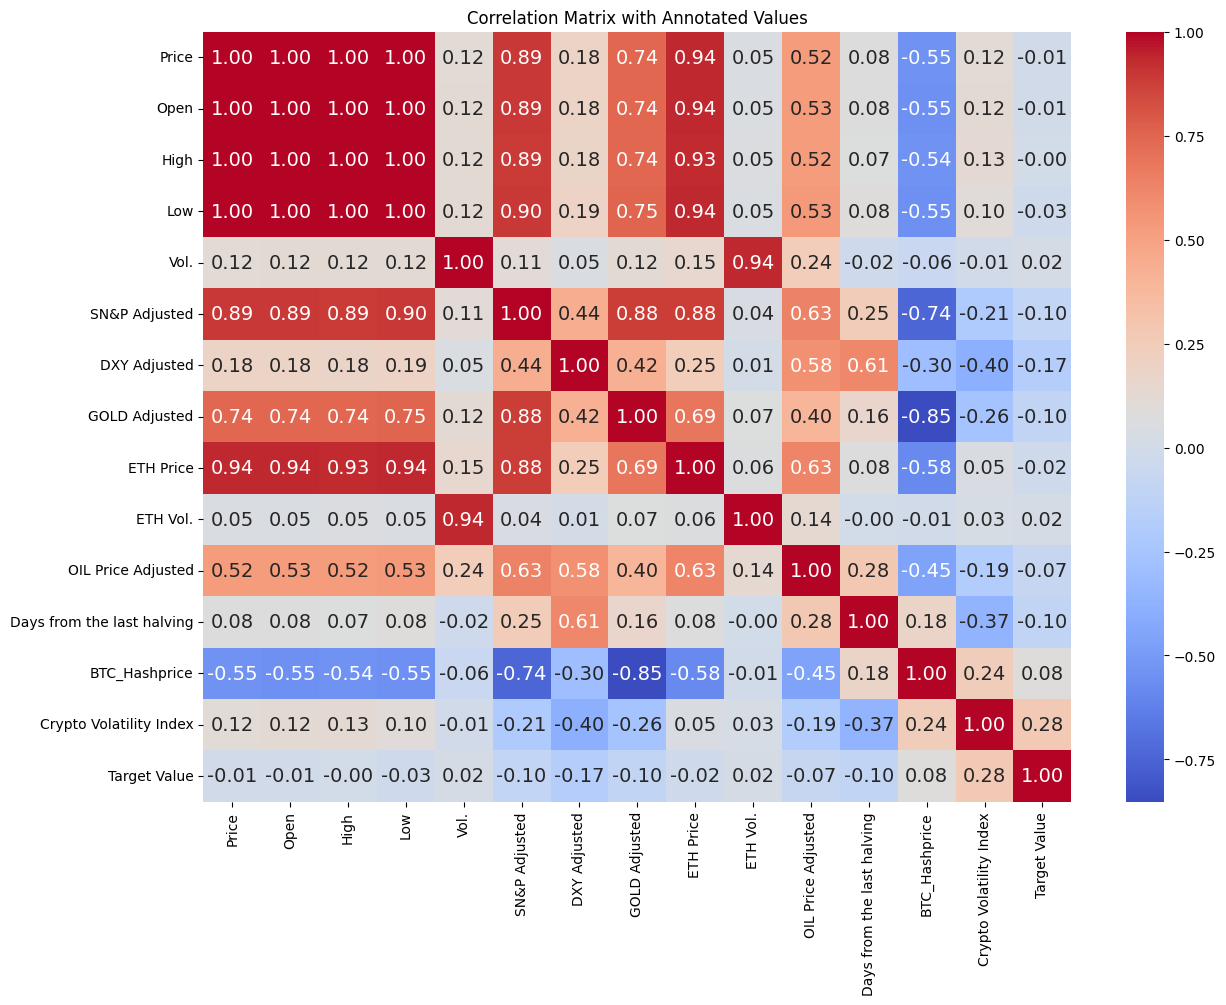

In [23]:
# 3.1 Correlation Matrix
# Select only numeric columns for correlation
# Select only numeric columns for correlation
numeric_data = updated_bitcoin_data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(14, 10))  # Increase figure size for better clarity
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={"size": 14})
plt.title('Correlation Matrix with Annotated Values')
plt.show()

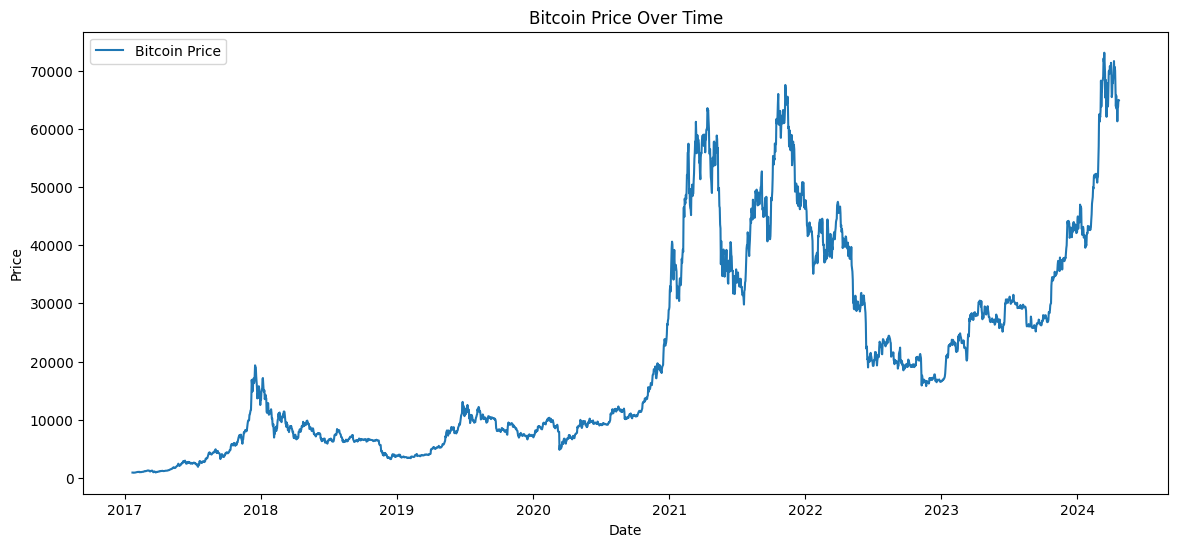

In [24]:
# Bitcoin Price Over Time
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Price'], label='Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()

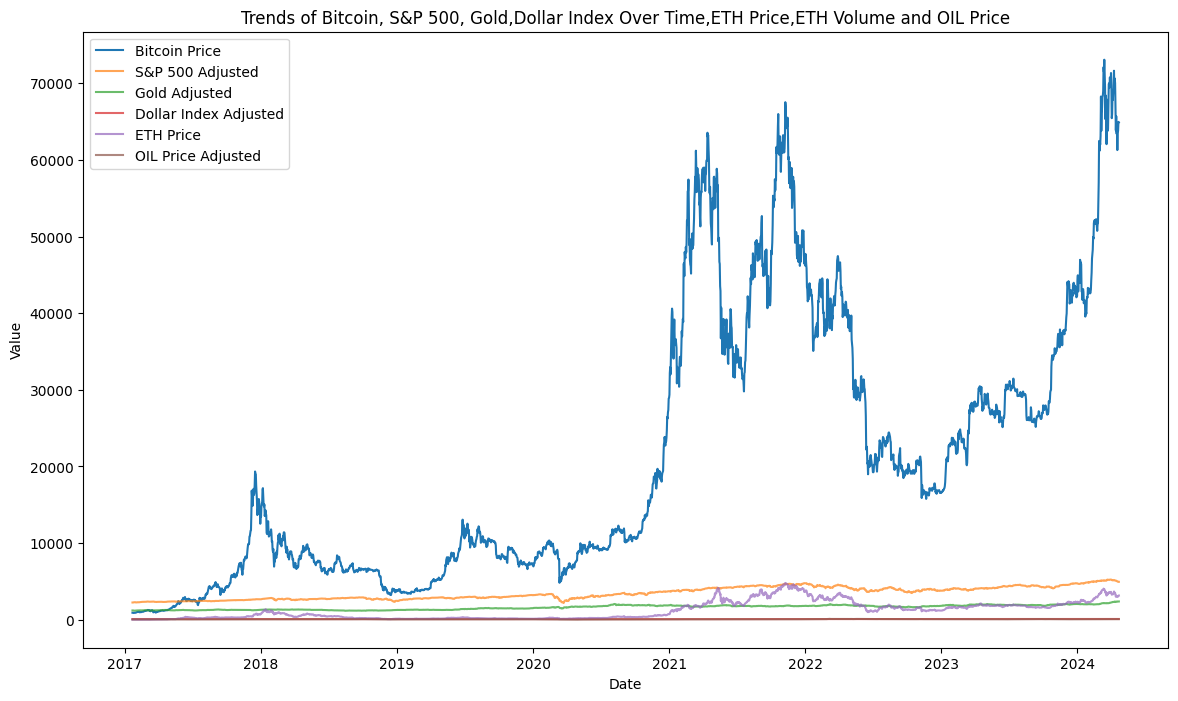

In [25]:
plt.figure(figsize=(14, 8))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Price'], label='Bitcoin Price')
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['SN&P Adjusted'], label='S&P 500 Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['GOLD Adjusted'], label='Gold Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['DXY Adjusted'], label='Dollar Index Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['ETH Price'], label='ETH Price', alpha=0.7)
#plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['ETH Vol.'], label='ETH Volume', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['OIL Price Adjusted'], label='OIL Price Adjusted', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends of Bitcoin, S&P 500, Gold,Dollar Index Over Time,ETH Price,ETH Volume and OIL Price')
plt.legend()
plt.show()

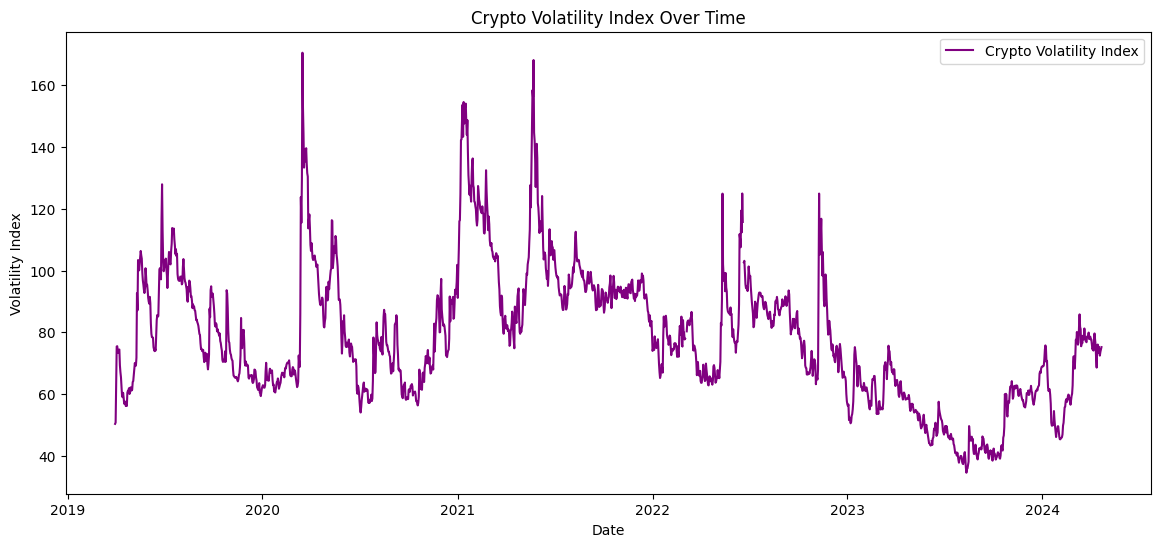

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Crypto Volatility Index'], color='purple', label='Crypto Volatility Index')
plt.xlabel('Date')
plt.ylabel('Volatility Index')
plt.title('Crypto Volatility Index Over Time')
plt.legend()
plt.show()

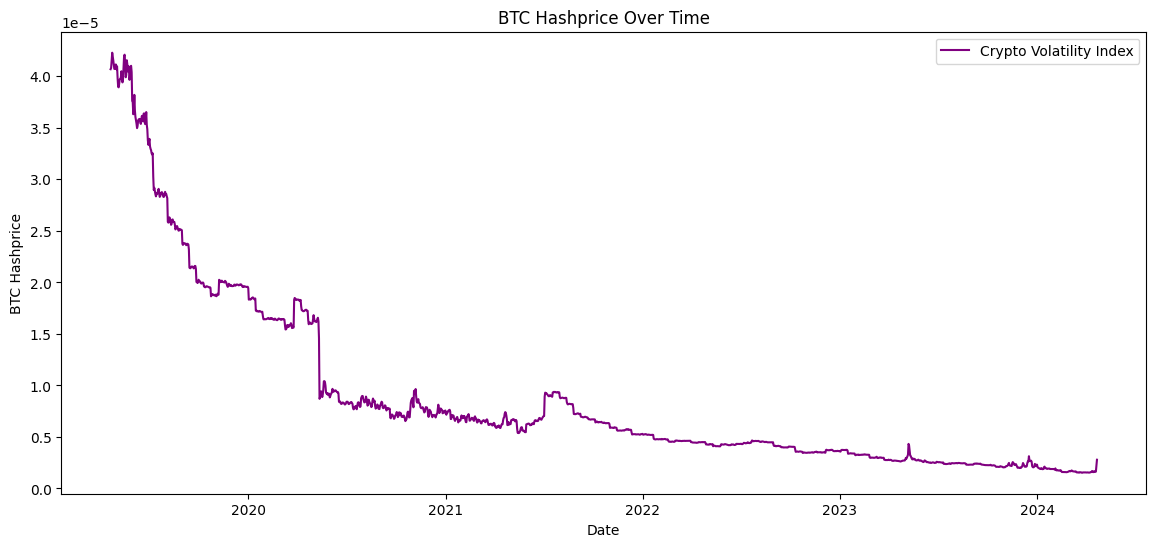

In [27]:
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['BTC_Hashprice'], color='purple', label='Crypto Volatility Index')
plt.xlabel('Date')
plt.ylabel('BTC Hashprice')
plt.title('BTC Hashprice Over Time')
plt.legend()
plt.show()

**After a web search, there is no historical data for Crypto Volatility Index before 30/4/2019, and couldn't find historical data for BTC Hashprice. Therefore, we will drop the rows with those missing values.**

In [28]:
updated_bitcoin_data = updated_bitcoin_data.drop(index=range(1827, 2648))

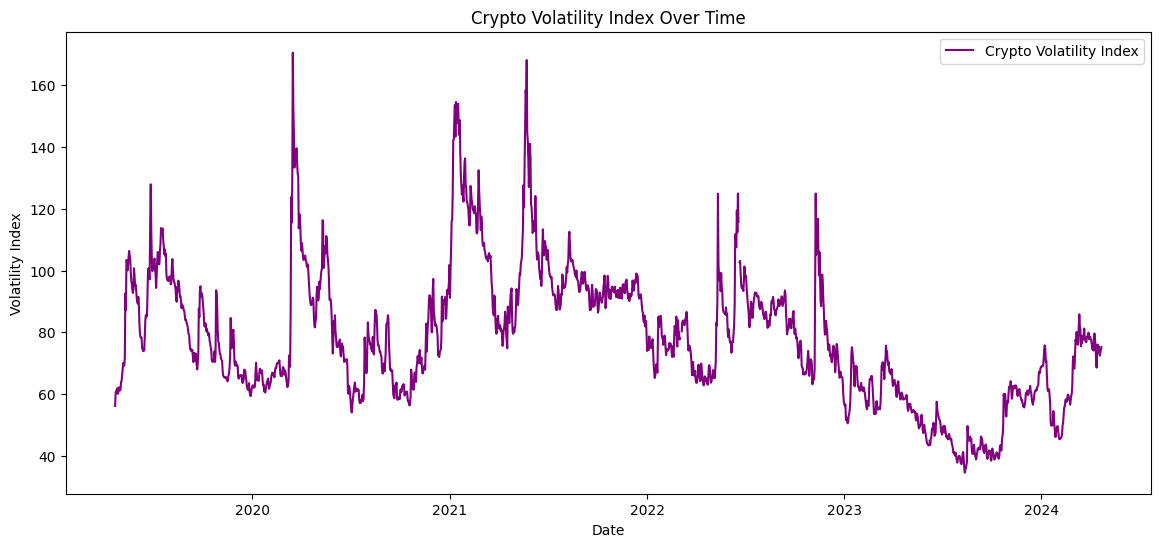

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Crypto Volatility Index'], color='purple', label='Crypto Volatility Index')
plt.xlabel('Date')
plt.ylabel('Volatility Index')
plt.title('Crypto Volatility Index Over Time')
plt.legend()
plt.show()

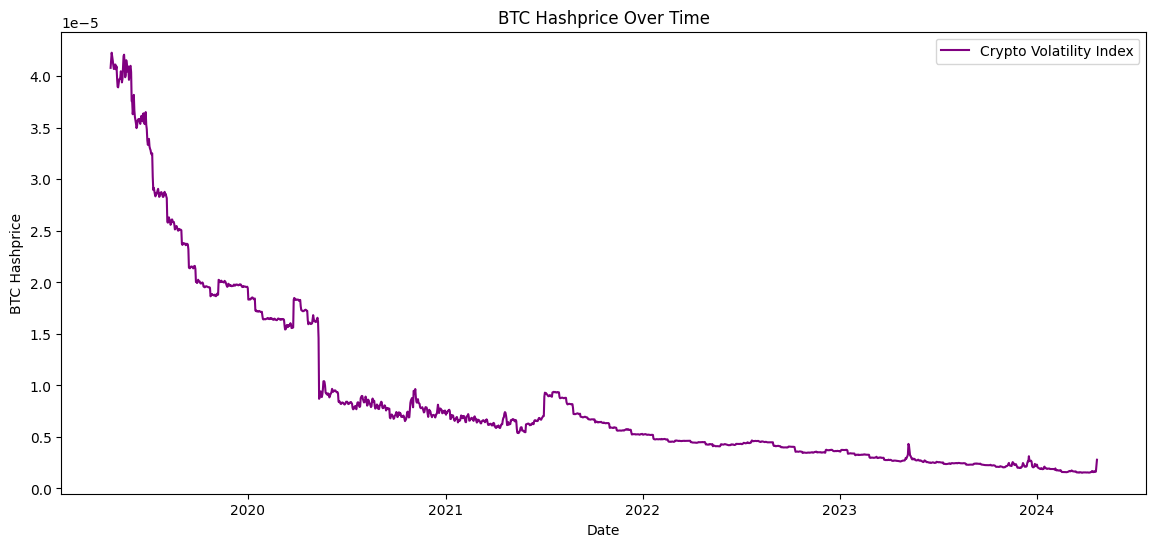

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['BTC_Hashprice'], color='purple', label='Crypto Volatility Index')
plt.xlabel('Date')
plt.ylabel('BTC Hashprice')
plt.title('BTC Hashprice Over Time')
plt.legend()
plt.show()

In [31]:
updated_bitcoin_data.tail()

,DATE,Price,Open,High,Low,Vol.,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
1822,2019-04-26,5298.3,5209.2,5469.3,5159.3,1030000.0,2917.6,96.509,1286.25,157.97,11520000.0,63.30,1021,0.000042,61.8611,0
1823,2019-04-25,5209.1,5415.6,5528.2,5137.4,955360.0,2912.8,96.460,1277.35,155.18,10780000.0,65.21,1020,0.000042,61.0823,1
1824,2019-04-24,5415.6,5511.2,5589.6,5346.8,994040.0,2926.1,96.135,1275.36,165.22,11610000.0,65.89,1019,0.000042,61.0430,0
1825,2019-04-23,5511.6,5346.5,5594.4,5291.4,900000.0,2908.5,96.205,1272.40,169.95,10170000.0,66.30,1018,0.000042,60.4151,1
1826,2019-04-22,5346.7,5248.2,5370.2,5170.2,920770.0,2896.3,95.975,1274.92,170.87,8620000.0,65.70,1017,0.000041,56.1304,0


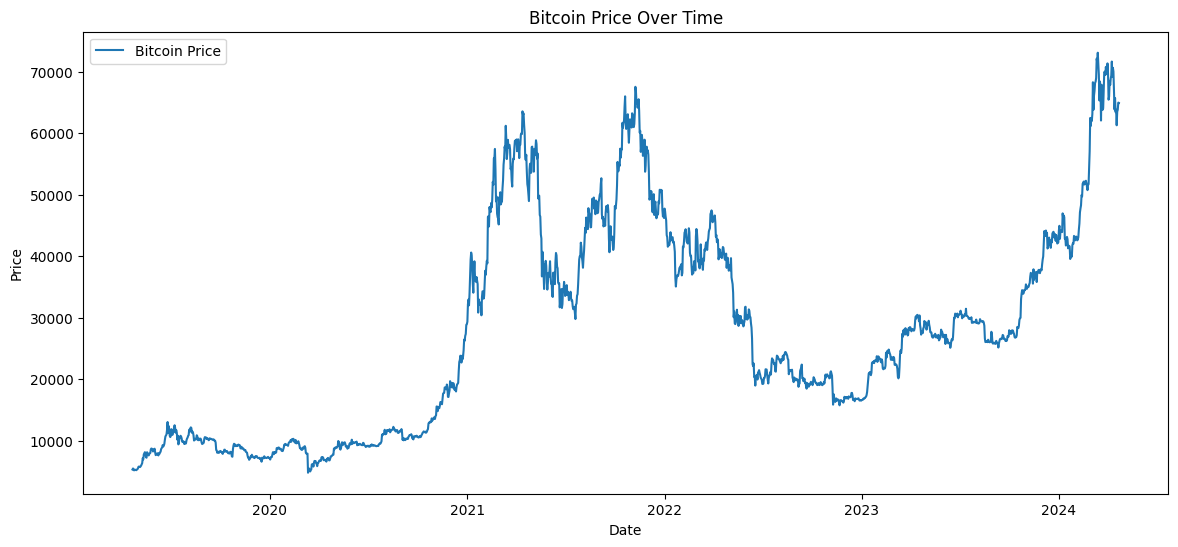

In [32]:
updated_bitcoin_data['DATE'] = pd.to_datetime(updated_bitcoin_data['DATE'])
plt.figure(figsize=(14, 6))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Price'], label='Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()

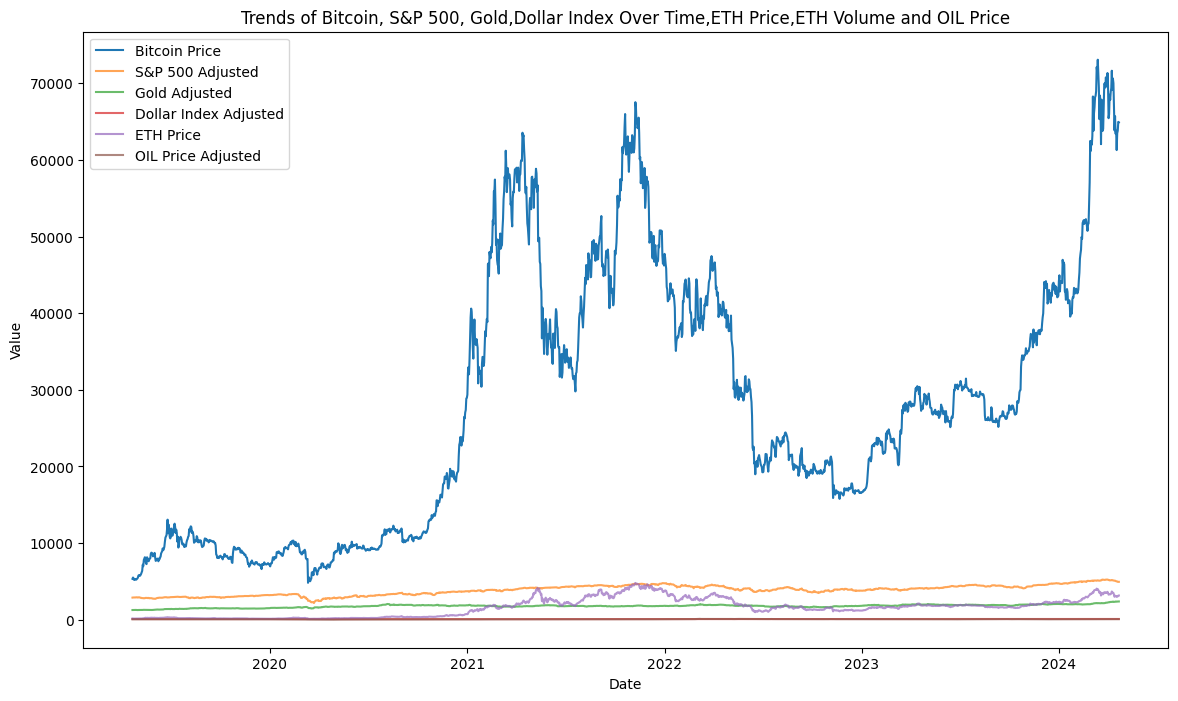

In [33]:
plt.figure(figsize=(14, 8))
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['Price'], label='Bitcoin Price')
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['SN&P Adjusted'], label='S&P 500 Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['GOLD Adjusted'], label='Gold Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['DXY Adjusted'], label='Dollar Index Adjusted', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['ETH Price'], label='ETH Price', alpha=0.7)
#plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['ETH Vol.'], label='ETH Volume', alpha=0.7)
plt.plot(updated_bitcoin_data['DATE'], updated_bitcoin_data['OIL Price Adjusted'], label='OIL Price Adjusted', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends of Bitcoin, S&P 500, Gold,Dollar Index Over Time,ETH Price,ETH Volume and OIL Price')
plt.legend()
plt.show()

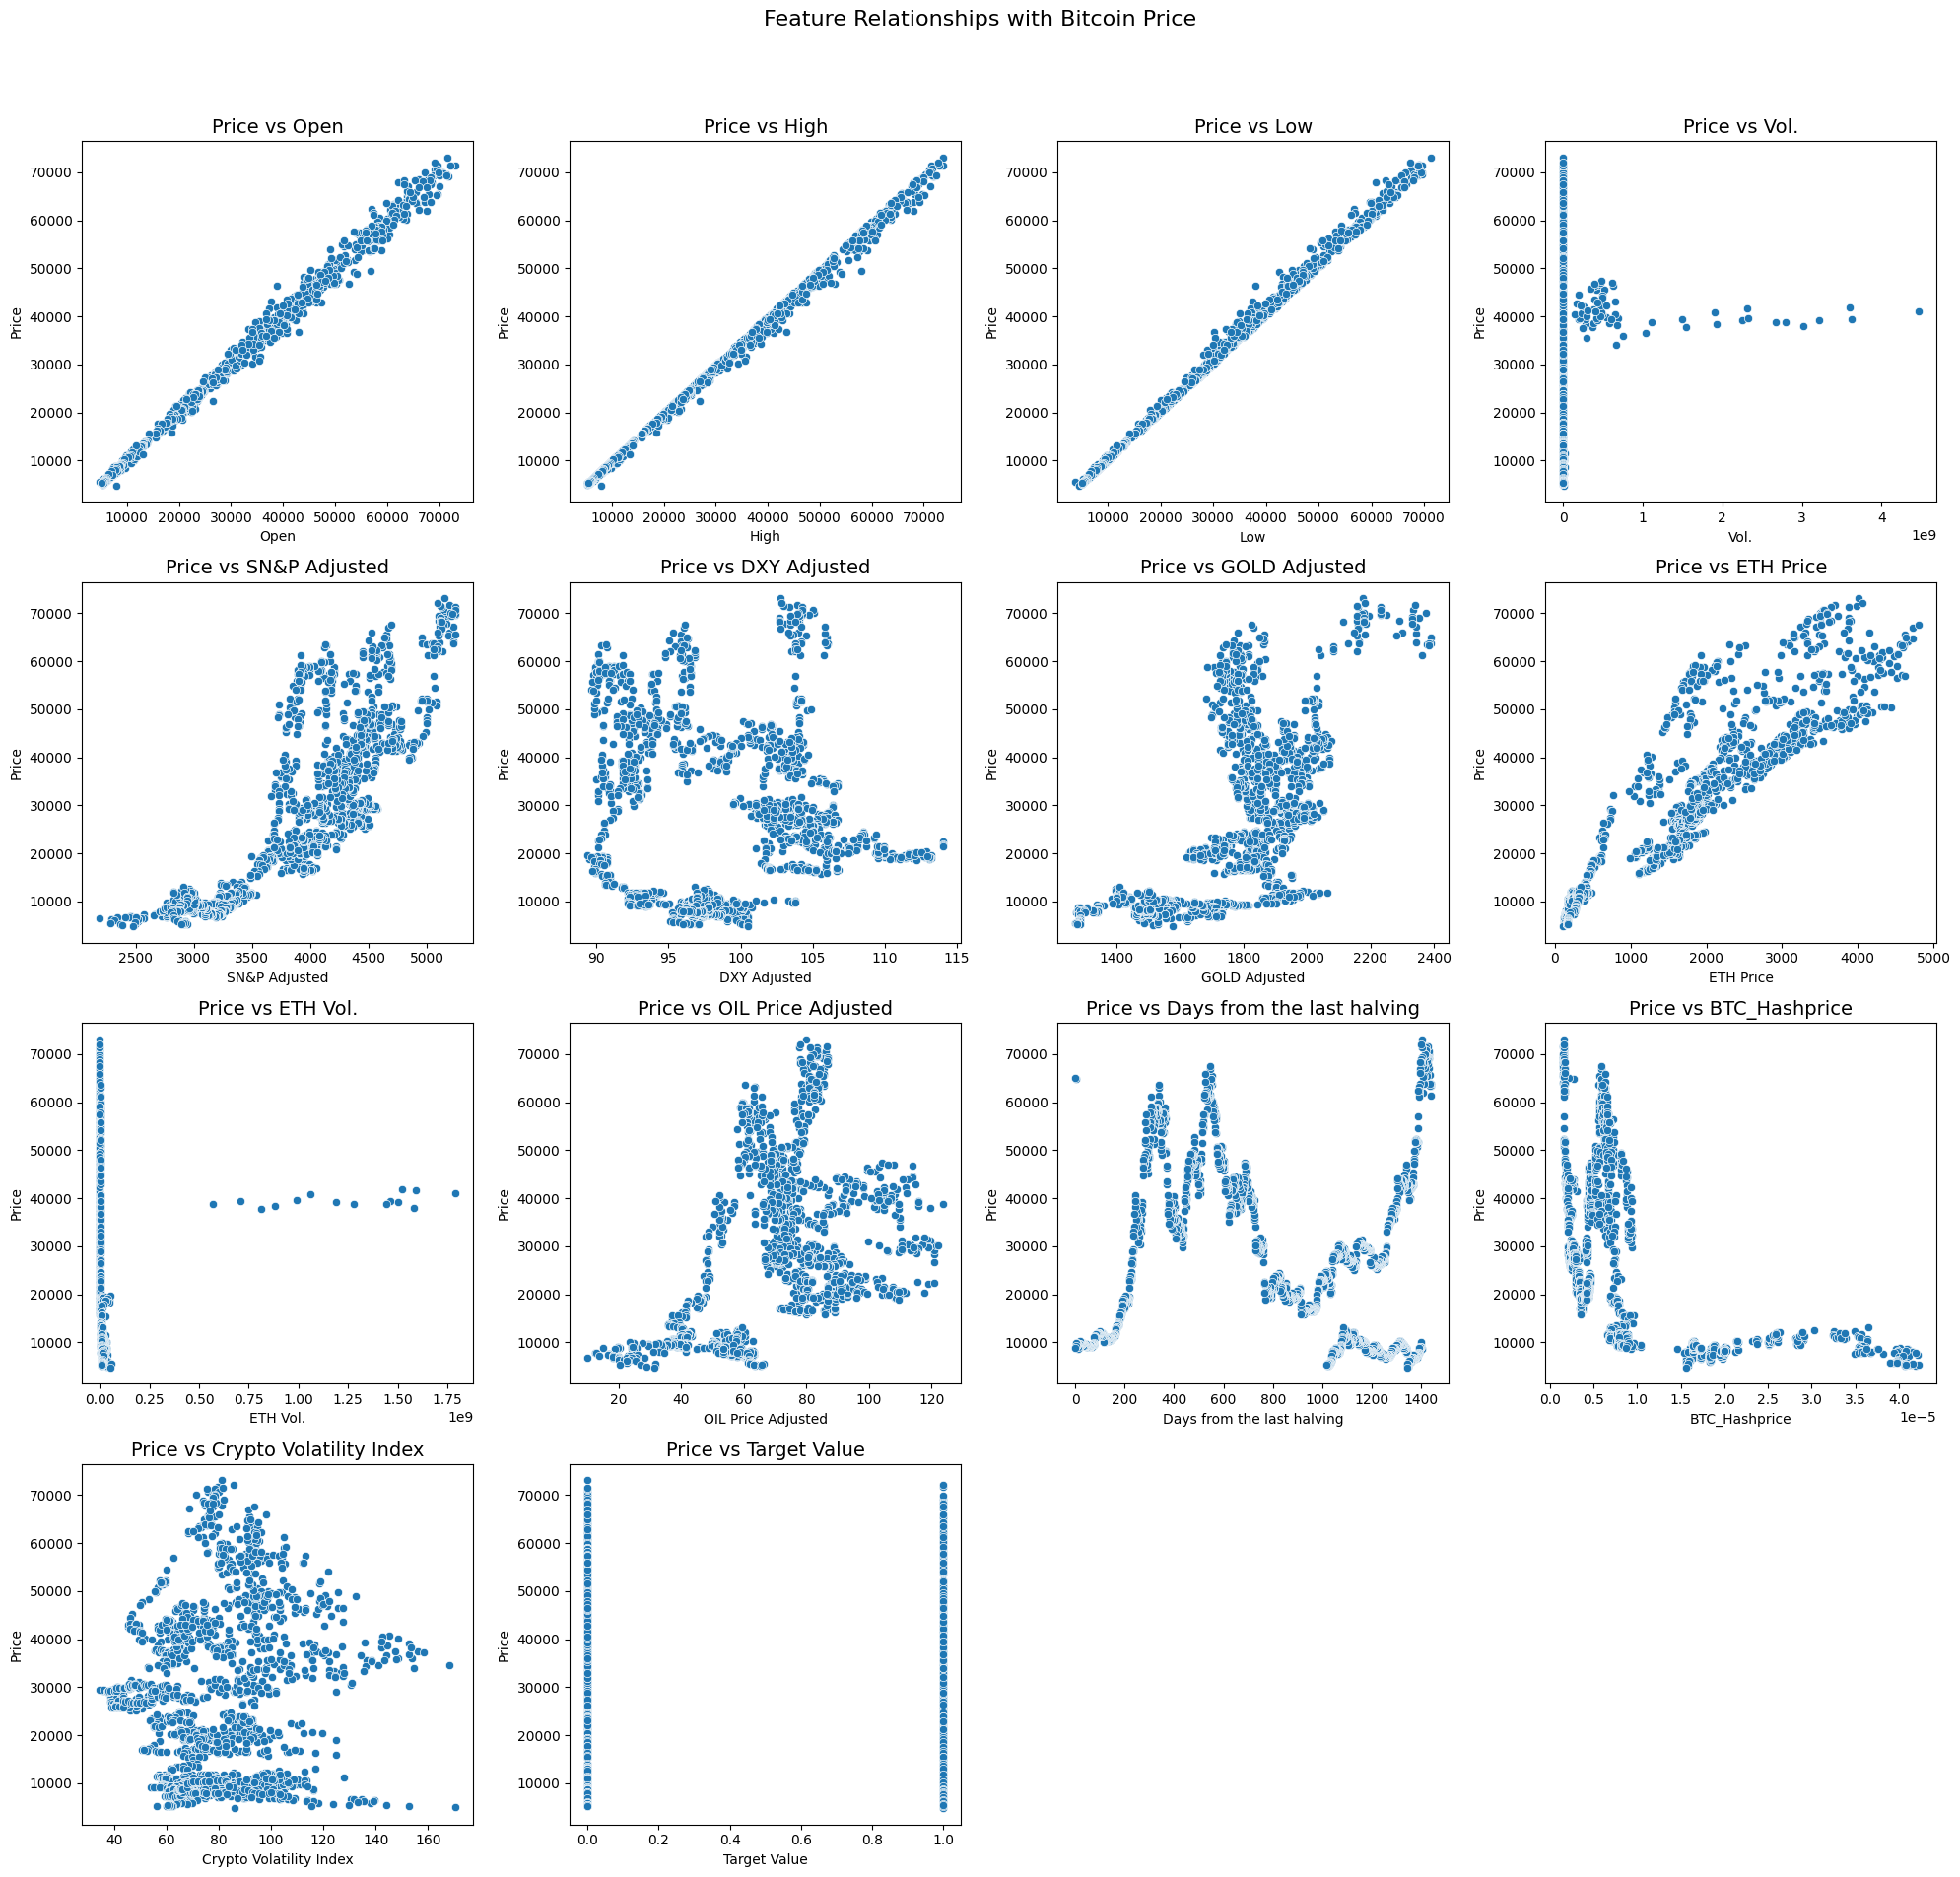

In [34]:
# Updating the feature list to include all numeric features except 'Price' itself
all_numeric_features = updated_bitcoin_data.select_dtypes(include=[np.number]).columns
features_to_scatter = [feature for feature in all_numeric_features if feature != 'Price']

# Setting up the figure and subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjust grid size for the number of features
fig.suptitle('Feature Relationships with Bitcoin Price', fontsize=16)

# Looping through the features to create scatter plots
for i, feature in enumerate(features_to_scatter):
    row, col = divmod(i, 4)  # Determine subplot position
    sns.scatterplot(x=updated_bitcoin_data[feature], y=updated_bitcoin_data['Price'], ax=axes[row, col])
    axes[row, col].set_title(f'Price vs {feature}', fontsize=14)

# Hide any unused subplots if the grid is larger than needed
for i in range(len(features_to_scatter), 4 * 4):
    row, col = divmod(i, 4)
    axes[row, col].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

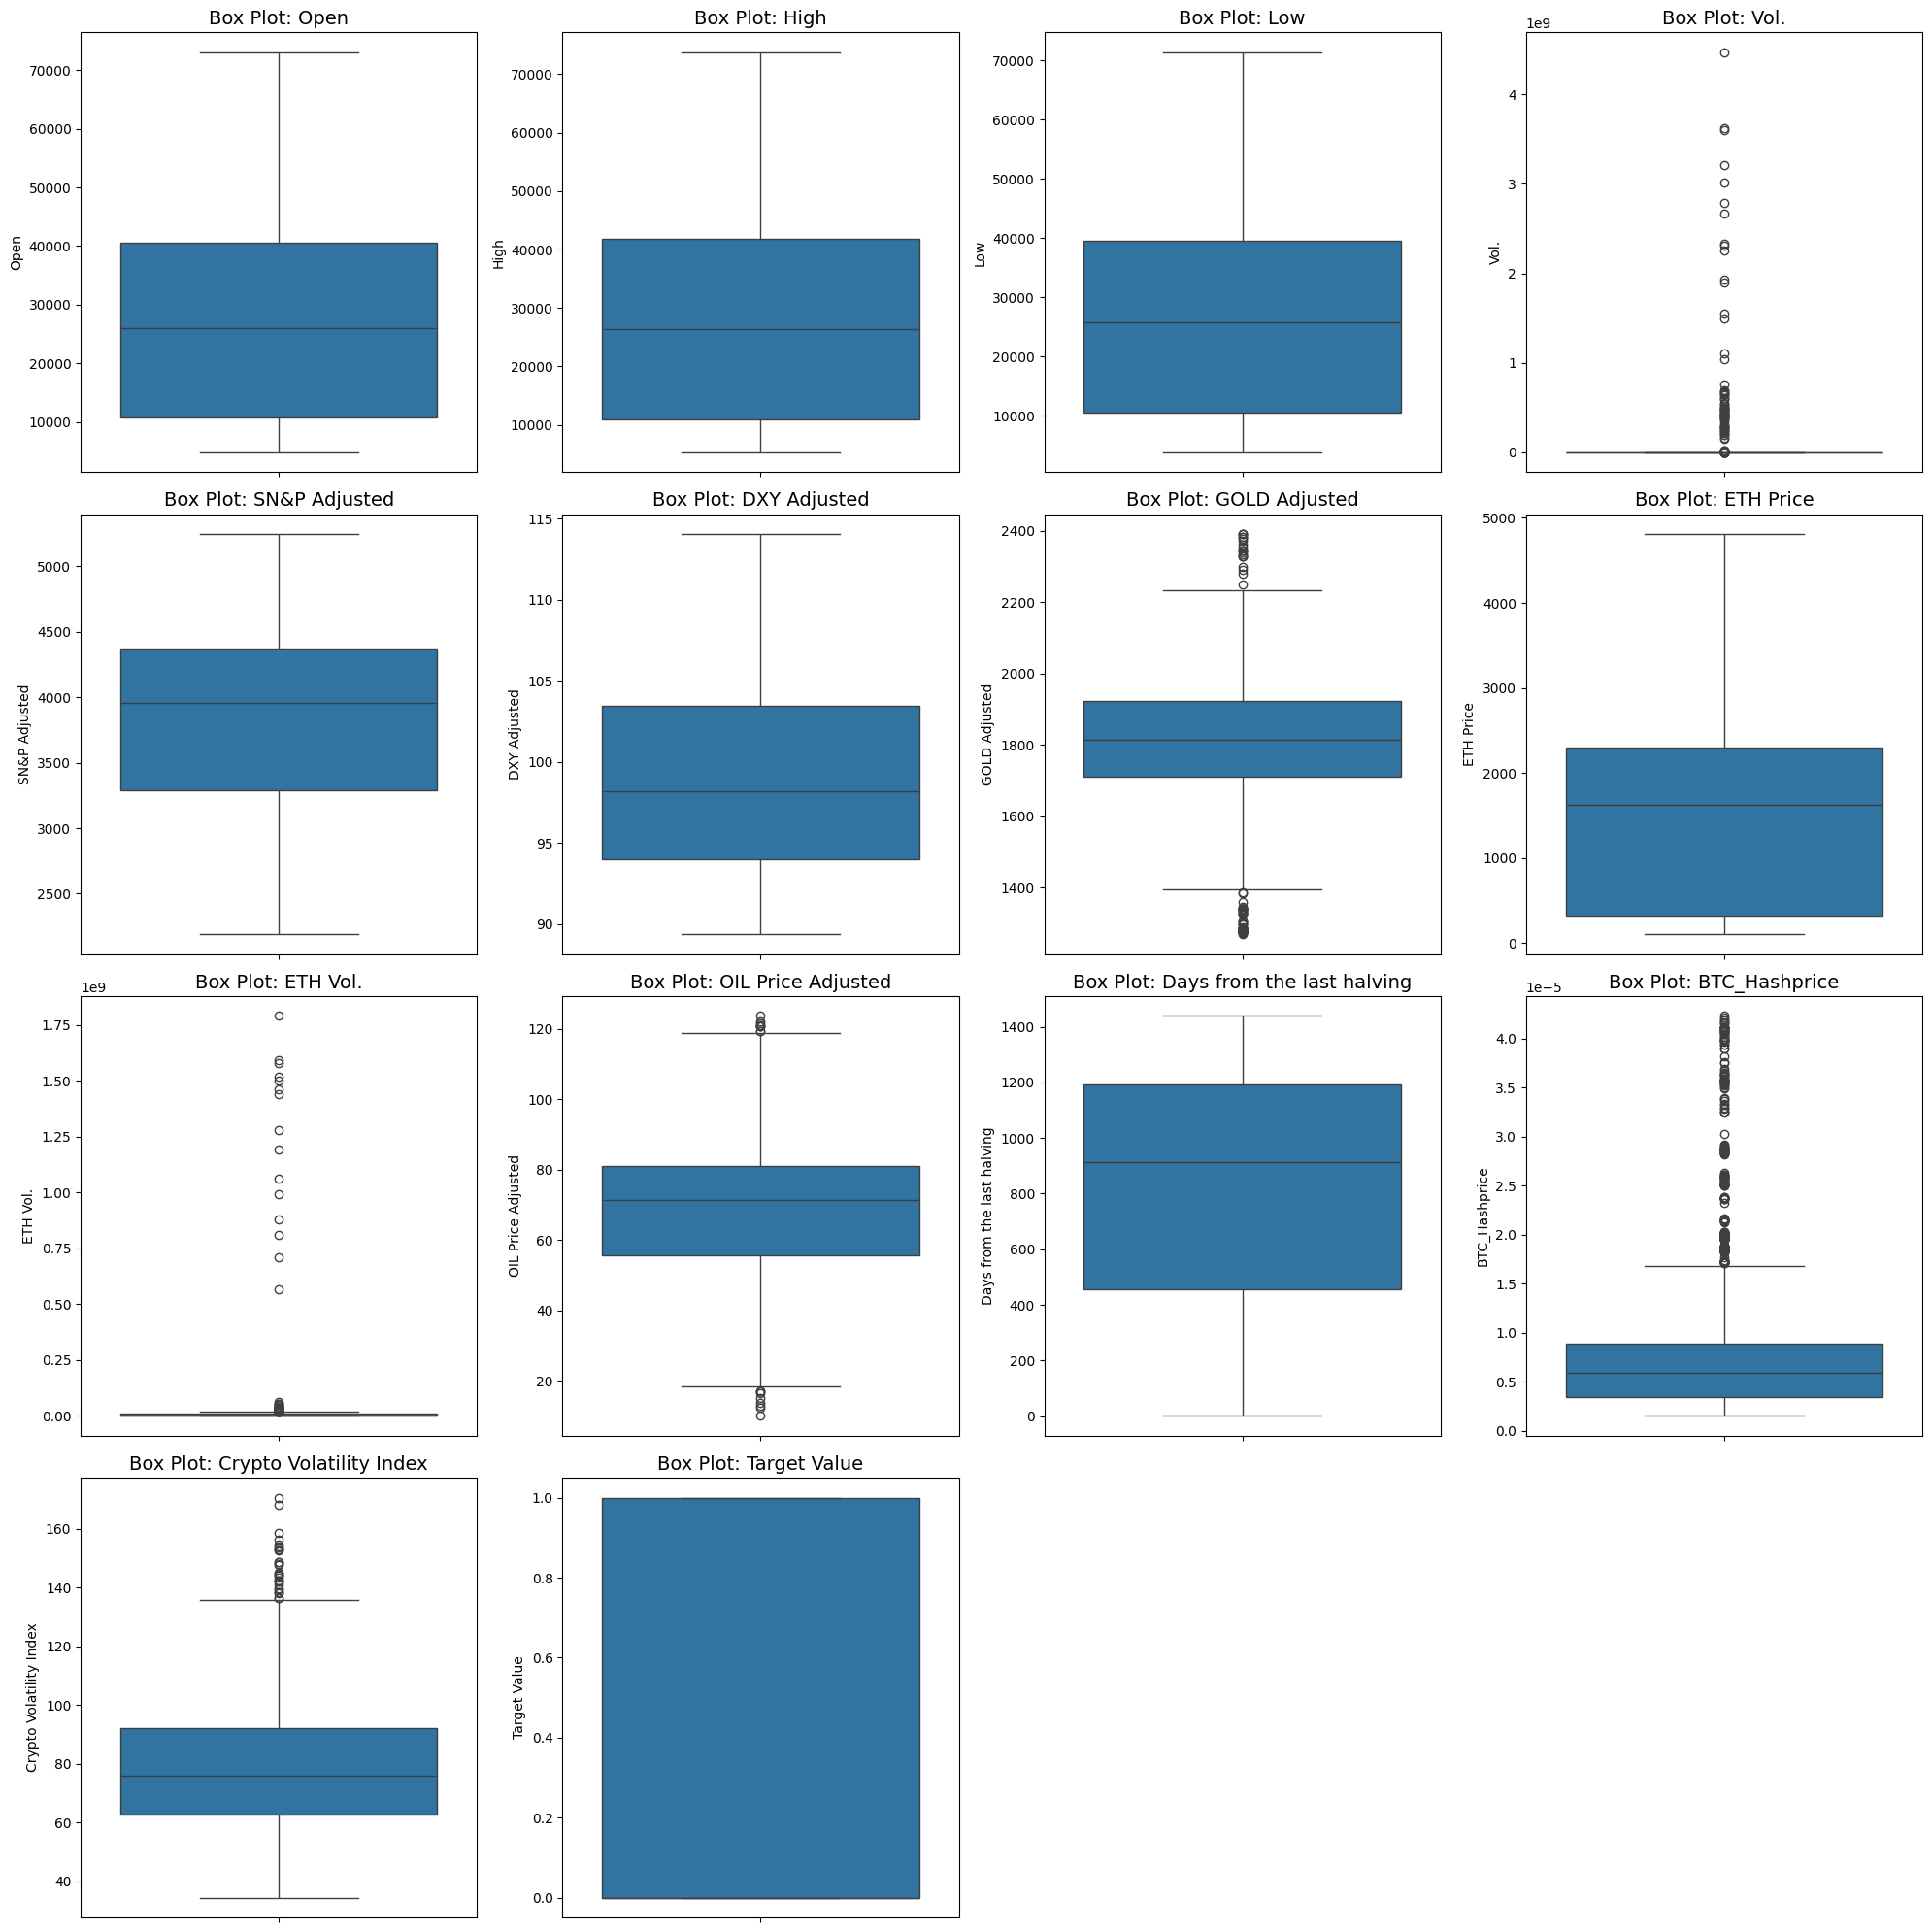

In [35]:
# Setting up the figure for box plots
num_features = updated_bitcoin_data.select_dtypes(include=[np.number]).columns
num_features = [feature for feature in num_features if feature != 'Price']  # Exclude 'Price' for clarity

# Determine grid size
num_plots = len(num_features)
rows = (num_plots // 4) + (1 if num_plots % 4 != 0 else 0)  # Adjust rows based on features

# Create subplots
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot box plots for each feature
for i, feature in enumerate(num_features):
    sns.boxplot(data=updated_bitcoin_data, y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot: {feature}', fontsize=14)

# Hide unused subplots if the grid is larger than needed
for i in range(len(num_features), len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

---

## Model Preparation

In [36]:
# Redefine features and target
features = [
    'ETH Vol.', 'Days from the last halving', 'Crypto Volatility Index',
    'GOLD Adjusted', 'OIL Price Adjusted', 'ETH Price', 'Low', 'High', 'Price', 
    'Open', 'Vol.', 'SN&P Adjusted', 'DXY Adjusted', 'BTC_Hashprice'
]

# Extract features and target
X = updated_bitcoin_data[features]
y = updated_bitcoin_data['Target Value']

# Check for NaN values before handling
print("Number of NaNs in each feature before handling:")
print(X.isna().sum())

# Fill missing values and explicitly update the original DataFrame
updated_bitcoin_data[features] = X.fillna(X.mean())

# Create a new DataFrame without any NaN values
cleaned_bitcoin_data_no_nan = updated_bitcoin_data.dropna()

# Verify that the new DataFrame has no NaN values
print("Number of NaNs in the new DataFrame:")
print(cleaned_bitcoin_data_no_nan.isna().sum())


Number of NaNs in each feature before handling:
ETH Vol.                      0
Days from the last halving    0
Crypto Volatility Index       4
GOLD Adjusted                 0
OIL Price Adjusted            0
ETH Price                     0
Low                           0
High                          0
Price                         0
Open                          0
Vol.                          0
SN&P Adjusted                 0
DXY Adjusted                  0
BTC_Hashprice                 0
dtype: int64
Number of NaNs in the new DataFrame:
DATE                          0
Price                         0
Open                          0
High                          0
Low                           0
Vol.                          0
SN&P Adjusted                 0
DXY Adjusted                  0
GOLD Adjusted                 0
ETH Price                     0
ETH Vol.                      0
OIL Price Adjusted            0
Days from the last halving    0
BTC_Hashprice                 0
Crypto

In [37]:
X = X.drop(X.index[0])

In [38]:
X

,ETH Vol.,Days from the last halving,Crypto Volatility Index,GOLD Adjusted,OIL Price Adjusted,ETH Price,Low,High,Price,Open,Vol.,SN&P Adjusted,DXY Adjusted,BTC_Hashprice
1,256050.0,1,74.3407,2390.45,83.14,3156.63,63131.7,65375.6,64961.1,63817.6,49330.0,4953.56,105.984,0.000002
2,645650.0,1439,73.6438,2390.45,83.14,3056.23,59693.3,65441.2,63799.1,63480.5,150340.0,4953.56,105.984,0.000002
3,423990.0,1438,72.4399,2378.25,82.73,3064.48,60822.3,64092.4,63481.4,61278.9,97380.0,5001.89,105.982,0.000002
4,524880.0,1437,74.0805,2360.81,82.69,2985.82,59820.8,64451.5,61278.9,63802.3,118920.0,5007.25,105.764,0.000002
5,560470.0,1436,75.3234,2382.83,85.36,3083.43,61715.6,64274.4,63805.3,63416.1,114960.0,5039.83,106.065,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,11520000.0,1021,61.8611,1286.25,63.30,157.97,5159.3,5469.3,5298.3,5209.2,1030000.0,2917.60,96.509,0.000042
1823,10780000.0,1020,61.0823,1277.35,65.21,155.18,5137.4,5528.2,5209.1,5415.6,955360.0,2912.80,96.460,0.000042
1824,11610000.0,1019,61.0430,1275.36,65.89,165.22,5346.8,5589.6,5415.6,5511.2,994040.0,2926.10,96.135,0.000042
1825,10170000.0,1018,60.4151,1272.40,66.30,169.95,5291.4,5594.4,5511.6,5346.5,900000.0,2908.50,96.205,0.000042


In [39]:
y = y.drop(y.index[1826:1827])

In [40]:
y

0       0
1       0
2       0
3       1
4       1
       ..
1821    0
1822    0
1823    1
1824    0
1825    1
Name: Target Value, Length: 1826, dtype: int64

In [41]:
# Ensure the 'Date' column is in datetime format
cleaned_bitcoin_data_no_nan['DATE'] = pd.to_datetime(cleaned_bitcoin_data_no_nan['DATE'])

# Sorting the data by date
cleaned_bitcoin_data_no_nan = cleaned_bitcoin_data_no_nan.sort_values(by='DATE')

# Define features (X) and target (y)
X = cleaned_bitcoin_data_no_nan.drop(columns=['DATE', 'Target Value'])  # Drop unnecessary columns
y = cleaned_bitcoin_data_no_nan['Target Value']  # Target variable

# Split data into training and testing based on date (e.g., 80% training, 20% testing)
split_date = cleaned_bitcoin_data_no_nan['DATE'].quantile(0.8)  # 80% for training
X_train = X[cleaned_bitcoin_data_no_nan['DATE'] <= split_date]
X_test = X[cleaned_bitcoin_data_no_nan['DATE'] > split_date]
y_train = y[cleaned_bitcoin_data_no_nan['DATE'] <= split_date]
y_test = y[cleaned_bitcoin_data_no_nan['DATE'] > split_date]

# Display sizes of the splits
print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")

Training Set Size: 1461
Testing Set Size: 366


In [42]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: Convert scaled data back to a DataFrame for easier interpretation (if needed)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Display the first few rows of the scaled training data
print("Scaled Training Data (First Few Rows):")
print(X_train_scaled_df.head())

# Check for NaN values after splitting
print("NaN values in training data:")
print(X_train.isna().sum())

print("NaN values in testing data:")
print(X_test.isna().sum())


Scaled Training Data (First Few Rows):
         Price      Open      High       Low      Vol.  SN&P Adjusted  \
1826 -1.181315 -1.185768 -1.185030 -1.185534 -0.143905      -1.360594   
1825 -1.171419 -1.179871 -1.171938 -1.178025 -0.143978      -1.339795   
1824 -1.177181 -1.169992 -1.172218 -1.174592 -0.143647      -1.309790   
1823 -1.189573 -1.175726 -1.175803 -1.187567 -0.143783      -1.332465   
1822 -1.184220 -1.188107 -1.179243 -1.186210 -0.143521      -1.324281   

      DXY Adjusted  GOLD Adjusted  ETH Price  ETH Vol.  OIL Price Adjusted  \
1826     -0.325543      -2.682364  -1.014871 -0.077616           -0.028013   
1825     -0.283862      -2.696965  -1.015614 -0.065536           -0.000749   
1824     -0.296548      -2.679815  -1.019434 -0.054314           -0.019380   
1823     -0.237651      -2.668285  -1.027542 -0.060782           -0.050280   
1822     -0.228771      -2.616720  -1.025289 -0.055015           -0.137072   

      Days from the last halving  BTC_Hashprice  Cryp

---

## Choosing the Model

In [43]:
models = {
    'Logistic Reg': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    'XGBoost': XGBClassifier(),
    'MLP Net': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Initialize a results dictionary
results = {}

# Fit each model, evaluate it, and store results
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_scores = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores) if y_scores is not None else None
    fpr, tpr, _ = roc_curve(y_test, y_scores) if y_scores is not None else (None, None, None)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'FPR': fpr,
        'TPR': tpr,
        'Confusion Matrix': cm
    }

# Convert the results dictionary into a DataFrame
result_df = pd.DataFrame(results).T
result_df



,Accuracy,AUC,FPR,TPR,Confusion Matrix
Logistic Reg,0.836066,0.883619,"[0.0, 0.0, 0.0, 0.006644518272425249, 0.006644...","[0.0, 0.015384615384615385, 0.0923076923076923...","[[299, 2], [58, 7]]"
Decision Tree,0.18306,0.313212,"[0.0, 0.8837209302325582, 0.9401993355481728, ...","[0.0, 0.49230769230769234, 0.8923076923076924,...","[[35, 266], [33, 32]]"
Random Forest,0.644809,0.421569,"[0.0, 0.006644518272425249, 0.0199335548172757...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.015384615384615385...","[[232, 69], [61, 4]]"
XGBoost,0.838798,0.819448,"[0.0, 0.0033222591362126247, 0.003322259136212...","[0.0, 0.0, 0.1076923076923077, 0.1076923076923...","[[277, 24], [35, 30]]"
MLP Net,0.822404,0.730284,"[0.0, 0.0, 0.0, 0.0033222591362126247, 0.00332...","[0.0, 0.015384615384615385, 0.0769230769230769...","[[301, 0], [65, 0]]"
AdaBoost,0.819672,0.830309,"[0.0, 0.0033222591362126247, 0.006644518272425...","[0.0, 0.0, 0.015384615384615385, 0.04615384615...","[[300, 1], [65, 0]]"
SVM (RBF),0.822404,0.764682,"[0.0, 0.0, 0.0033222591362126247, 0.0033222591...","[0.0, 0.015384615384615385, 0.0153846153846153...","[[301, 0], [65, 0]]"
Gradient Boosting,0.333333,0.622872,"[0.0, 0.0033222591362126247, 0.003322259136212...","[0.0, 0.0, 0.015384615384615385, 0.01538461538...","[[69, 232], [12, 53]]"
Naive Bayes,0.784153,0.67493,"[0.0, 0.0033222591362126247, 0.003322259136212...","[0.0, 0.0, 0.03076923076923077, 0.030769230769...","[[282, 19], [60, 5]]"


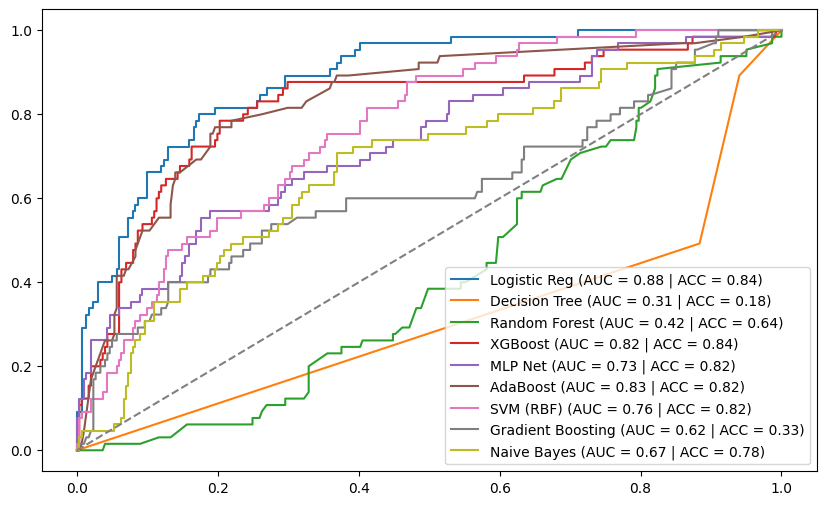

In [44]:

plt.figure(figsize=(10, 6))
for k in models:
    plt.plot(results[k]['FPR'], results[k]['TPR'], label=f'{k} (AUC = {results[k]["AUC"]:.2f} | ACC = {results[k]["Accuracy"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.legend()

In [45]:
confusion_matrices = {}

# Loop through results to extract confusion matrices
for model_name, metrics in results.items():
    cm = metrics['Confusion Matrix']
    confusion_matrices[model_name] = {
        'True Negative': cm[0][0],
        'False Positive': cm[0][1],
        'False Negative': cm[1][0],
        'True Positive': cm[1][1],
    }

# Convert to a DataFrame for display
confusion_matrix_df = pd.DataFrame.from_dict(confusion_matrices, orient='index')
confusion_matrix_df

,True Negative,False Positive,False Negative,True Positive
Logistic Reg,299,2,58,7
Decision Tree,35,266,33,32
Random Forest,232,69,61,4
XGBoost,277,24,35,30
MLP Net,301,0,65,0
AdaBoost,300,1,65,0
SVM (RBF),301,0,65,0
Gradient Boosting,69,232,12,53
Naive Bayes,282,19,60,5


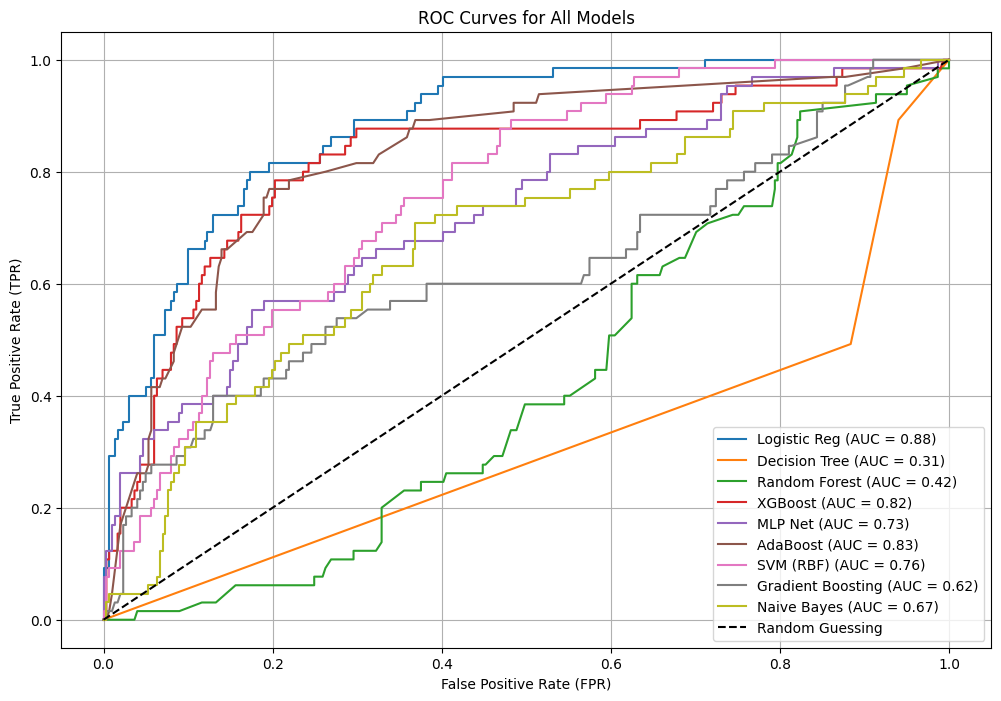

In [46]:
# Plot the ROC curves for each model
plt.figure(figsize=(12, 8))

# Loop through each model's results to plot ROC curves
for model_name, metrics in results.items():
    if metrics['FPR'] is not None and metrics['TPR'] is not None:  # Ensure ROC data exists
        plt.plot(metrics['FPR'], metrics['TPR'], label=f"{model_name} (AUC = {metrics['AUC']:.2f})")

# Add details to the plot
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")  # Random guessing line
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

C:\Users\maxsa\AppData\Local\Temp\ipykernel_17748\155678699.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x='Model', y='Accuracy', ax=axes[0], palette="Blues_d")
C:\Users\maxsa\AppData\Local\Temp\ipykernel_17748\155678699.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\maxsa\AppData\Local\Temp\ipykernel_17748\155678699.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x='Model', y='AUC', ax=axes[1], palette="Greens_d")
C:\Users\maxsa\AppData\Local\Temp\ipykernel_17748

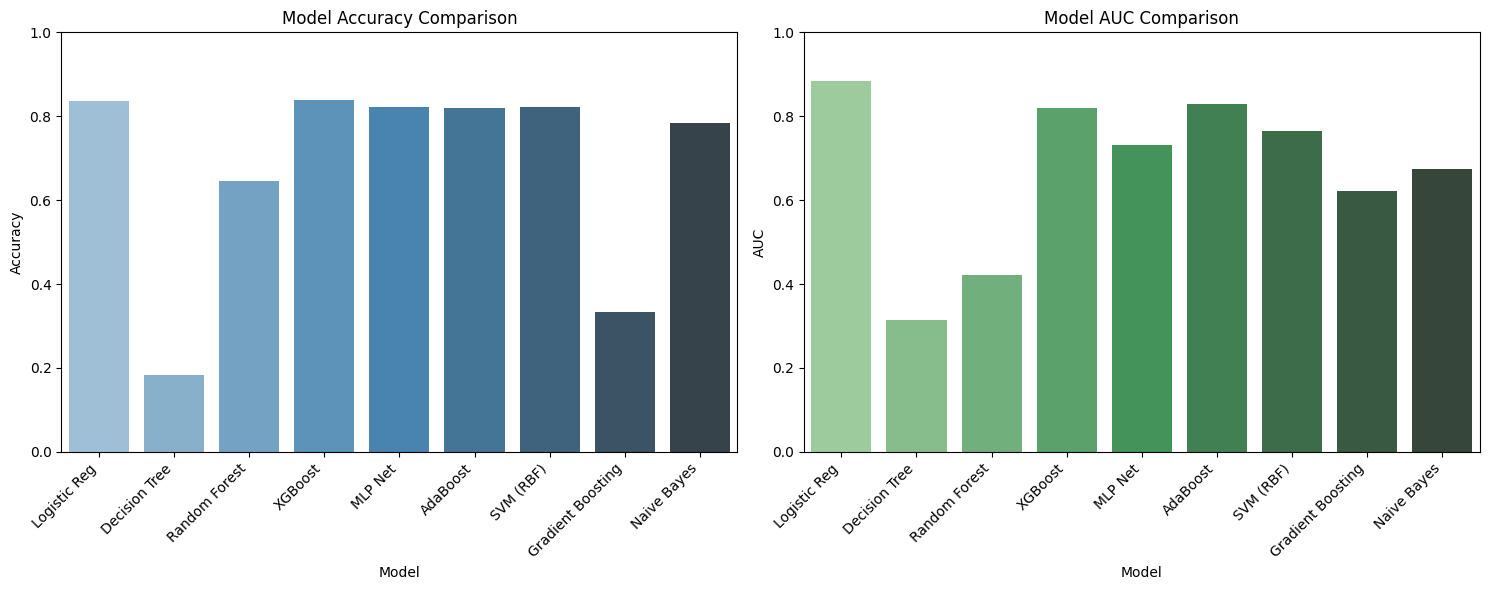

In [47]:
# Create a DataFrame for the performance metrics
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [metrics['Accuracy'] for metrics in results.values()],
    'AUC': [metrics['AUC'] for metrics in results.values()]
})

# Plot the Accuracy and AUC side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Bar Plot
sns.barplot(data=performance_df, x='Model', y='Accuracy', ax=axes[0], palette="Blues_d")
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim(0, 1)

# AUC Bar Plot
sns.barplot(data=performance_df, x='Model', y='AUC', ax=axes[1], palette="Greens_d")
axes[1].set_title("Model AUC Comparison")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [48]:
features = [
    'ETH Vol.', 'Days from the last halving', 'Crypto Volatility Index',
    'GOLD Adjusted', 'OIL Price Adjusted', 'ETH Price', 'Low', 'High', 'Price', 
    'Open', 'Vol.', 'SN&P Adjusted', 'DXY Adjusted', 'BTC_Hashprice'
]
X = cleaned_bitcoin_data_no_nan[features]
y = cleaned_bitcoin_data_no_nan['Target Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

,Feature,Importance
10,Vol.,0.125991
0,ETH Vol.,0.116415
2,Crypto Volatility Index,0.094375
9,Open,0.067418
7,High,0.065705
6,Low,0.065659
13,BTC_Hashprice,0.063276
5,ETH Price,0.062788
8,Price,0.062752
1,Days from the last halving,0.058402


---

In [49]:
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False] 
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_scaled, y_train)

# Use the best Random Forest estimator
best_rf_model = grid_search_rf.best_estimator_

# Make predictions with Random Forest
y_pred_rf = best_rf_model.predict(X_test_scaled)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [50]:
# Ensure predictions are recomputed
y_pred_rf = rf_model.predict(scaler.transform(X_test))

# Evaluate the Random Forest model
print("Random Forest Model Evaluation:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('Accuracy:', accuracy_score(y_test, y_pred_rf))

Random Forest Model Evaluation:
[[303  32]
 [ 93  29]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       335
           1       0.48      0.24      0.32       122

    accuracy                           0.73       457
   macro avg       0.62      0.57      0.57       457
weighted avg       0.69      0.73      0.69       457

Accuracy: 0.7264770240700219


In [51]:
auc = roc_auc_score(y_test, rf_model.predict_proba(scaler.transform(X_test))[:, 1])
print('AUC:', auc)

AUC: 0.7388304379740641


In [52]:
mcc = matthews_corrcoef(y_test, y_pred_rf)
print('Matthews Correlation Coefficient:', mcc)

Matthews Correlation Coefficient: 0.18494221132502356


In [53]:
logloss = log_loss(y_test, rf_model.predict_proba(scaler.transform(X_test)))
print('Log Loss:', logloss)

Log Loss: 0.6607862670424058


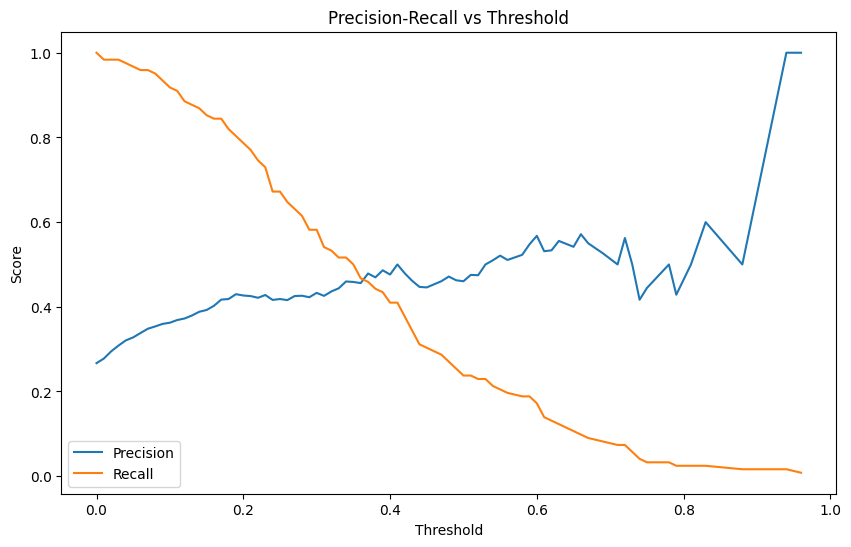

In [54]:
y_scores = rf_model.predict_proba(scaler.transform(X_test))[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.title('Precision-Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [55]:
# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

# Create a DataFrame for the metrics
error_metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 
               'Root Mean Squared Error (RMSE)', 'R-Squared (R2)'],
    'Value': [mae, mse, rmse, r2]
})

# Display the DataFrame
print(error_metrics_df)

                           Metric     Value
0       Mean Absolute Error (MAE)  0.273523
1        Mean Squared Error (MSE)  0.273523
2  Root Mean Squared Error (RMSE)  0.522994
3                  R-Squared (R2) -0.397724
